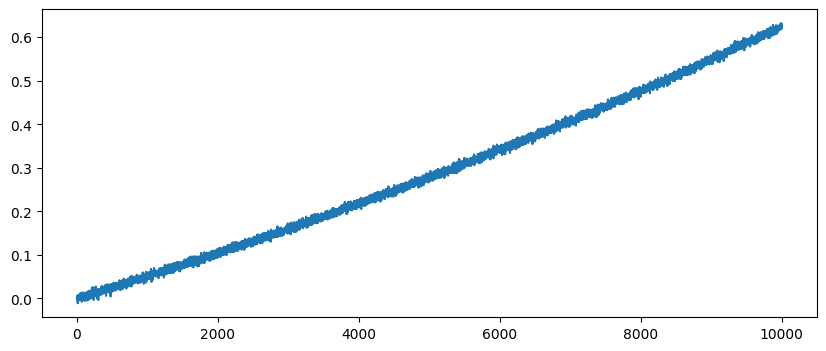

epoch   1 | train 0.828168 | val 0.022542
epoch   2 | train 0.019156 | val 0.007854
epoch   3 | train 0.003677 | val 0.002443
epoch   4 | train 0.001254 | val 0.001879
epoch   5 | train 0.000649 | val 0.000499
epoch   6 | train 0.000480 | val 0.000864


In [1]:
from dataset import *
from model import *
from train import *


def build_loaders(y, n, m, batch_size=128, stride=1, split=0.8):
    T = len(y)
    cut = int(T * split)
    train_ds = WindowDataset(y, n=n, m=m, stride=stride, start=0, end=cut)
    val_ds = WindowDataset(y, n=n, m=m, stride=stride, start=cut, end=T)

    train_loader = DataLoader(
        train_ds, batch_size=batch_size, shuffle=True, drop_last=True
    )
    val_loader = DataLoader(
        val_ds, batch_size=batch_size, shuffle=False, drop_last=False
    )
    return train_loader, val_loader


# 生成数据
x = np.arange(10_000, dtype=np.float32)
y = generate_poly_series(T=10_000, noise_std=0.005, seed=0)

plt.figure(figsize=(10, 4))
plt.plot(x, y, label="y")
plt.show()

n, m = 64, 16
train_loader, val_loader = build_loaders(y, n, m, batch_size=256, stride=1, split=0.8)

# 你自己设定模型超参，注意维度一致：
# encoder input_size=1
# decoder input_size=2（因为有 bos_flag）
H = 128
num_heads = 8
num_layers = 2
dropout = 0.1

encoder = TransformerEncoder(
    input_size=1,
    key_size=H,
    query_size=H,
    value_size=H,
    num_hiddens=H,
    norm_shape=H,
    ffn_num_input=H,
    ffn_num_hiddens=4 * H,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
)

decoder = TransformerDecoder(
    input_size=2,  # 关键：value+bos_flag
    output_size=1,
    key_size=H,
    query_size=H,
    value_size=H,
    num_hiddens=H,
    norm_shape=H,
    ffn_num_input=H,
    ffn_num_hiddens=4 * H,
    num_heads=num_heads,
    num_layers=num_layers,
    dropout=dropout,
)

net = EncoderDecoder(encoder, decoder)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
train_seq2seq_regression(
    net, train_loader, val_loader, num_epochs=6, lr=1e-3, device=device
)


In [2]:
import torch

@torch.no_grad()
def predict_autoregressive(net, X, m, device=None, X_valid_len=None):
    net.eval()
    if device is None:
        device = next(net.parameters()).device
    X = X.to(device)
    dtype = X.dtype

    B = X.shape[0]
    if X_valid_len is None:
        X_valid_len = torch.full((B,), X.shape[1], dtype=torch.long, device=device)
    else:
        X_valid_len = X_valid_len.to(device)

    # 1) encoder
    enc_outputs = net.encoder(X, X_valid_len)
    state = net.decoder.init_state(enc_outputs, X_valid_len)

    # 2) 初始 token: [0.0, 1.0]
    val0 = torch.zeros((B, 1, 1), device=device, dtype=dtype)
    flag1 = torch.ones((B, 1, 1), device=device, dtype=dtype)
    dec_step = torch.cat([val0, flag1], dim=-1)   # (B,1,2)

    preds = []
    for _ in range(m):
        out, state = net.decoder(dec_step, state)  # out: (B,1, out_dim)
        print(out.shape)
        # 只取“预测值”这一维：
        # - 如果 out_dim=2（value+flag），取 [:,:,:1]
        # - 如果 out_dim=1，[:,:,:1] 也一样成立
        y_hat = out   # (B,1,1)
        preds.append(y_hat)

        # 下一步 token: [y_hat, 0.0]
        flag0 = torch.zeros((B, 1, 1), device=device, dtype=dtype)
        dec_step = torch.cat([y_hat, flag0], dim=-1)  # (B,1,2)

    return torch.cat(preds, dim=1)  # (B,m,1)


In [3]:
@torch.no_grad()
def eval_autoregressive_mse(net, data_loader, device):
    net.eval()
    se_sum, count = 0.0, 0
    for X, X_len, Y, Y_len in data_loader:
        X, X_len, Y = X.to(device), X_len.to(device), Y.to(device)
        Y_hat = predict_autoregressive(net, X, m=Y.shape[1], device=device, X_valid_len=X_len)
        se_sum += ((Y_hat - Y) ** 2).sum().item()
        count += Y.numel()
    return se_sum / max(count, 1)

# 用法
mse = eval_autoregressive_mse(net, val_loader, device)
print("autoregressive MSE:", mse)


torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256,

In [4]:
import numpy as np
import torch

@torch.no_grad()
def sliding_forecast_curves(net, series_np, n=64, m=64, horizons=(1,16,64),
                            batch_size=256, device=None):
    """
    series_np: (T,) np.float32
    返回 dict: {h: pred_curve (T,) np.float32 with NaN where undefined}
    """
    net.eval()
    if device is None:
        device = next(net.parameters()).device

    x = series_np.astype(np.float32)
    T = len(x)
    num_windows = T - n - m + 1
    if num_windows <= 0:
        raise ValueError("series too short for given n,m")

    # 准备所有窗口输入 (num_windows, n, 1)
    X_all = np.stack([x[pos:pos+n] for pos in range(num_windows)], axis=0)  # (W,n)
    X_all = torch.from_numpy(X_all).unsqueeze(-1).to(device)               # (W,n,1)
    X_len = torch.full((num_windows,), n, dtype=torch.long, device=device)

    # 输出曲线（按真实时间轴对齐）
    preds = {h: np.full(T, np.nan, dtype=np.float32) for h in horizons}

    # 分批 rollout
    for s in range(0, num_windows, batch_size):
        e = min(s + batch_size, num_windows)
        Xb = X_all[s:e]
        Lb = X_len[s:e]

        Yb = predict_autoregressive(net, Xb, m=m, device=device, X_valid_len=Lb)  # (B,m,1)
        Yb = Yb.squeeze(-1).cpu().numpy()  # (B,m)

        for idx_in_batch, pos in enumerate(range(s, e)):
            for h in horizons:
                k = h - 1
                t = pos + n + k
                preds[h][t] = Yb[idx_in_batch, k]

    return preds


torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256, 1, 1])
torch.Size([256,

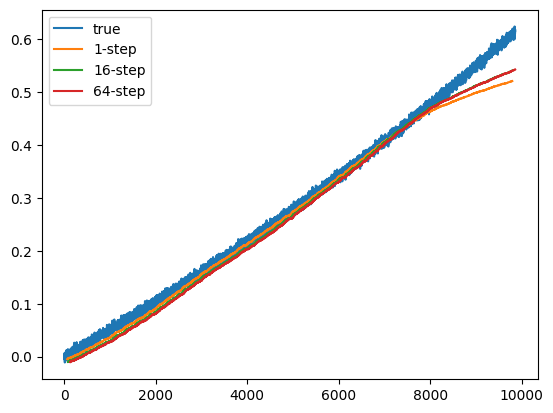

In [5]:
import numpy as np
import torch
import matplotlib.pyplot as plt

# --- config ---
n = 64
m = 64
batch_size = 256
horizons = [1, 16, 64]  # 1-step / 16-step / 64-step

# 让窗口数刚好 = 38*256 = 9728
L = 9855  # = 9728 + 64 + 64 - 1
test_x = y[0 : 0 + L].astype(np.float32)  # (L,)

# --- make windows once ---
x1 = torch.from_numpy(test_x).to(device)                    # (L,)
W = L - n - m + 1                                           # should be 1792
Xw = x1.unfold(0, n, 1)[:W]                                 # (W, n)
Xw = Xw.reshape(-1, n, 1)                                   # (W,64,1)

# --- allocate curves on timeline ---
pred = {h: np.full(L, np.nan, dtype=np.float32) for h in horizons}

# --- batch rollout ---
for s in range(0, W, batch_size):
    e = s + batch_size
    Xb = Xw[s:e]                                            # (B,64,1)
    # (B,64,1)
    Yb = predict_autoregressive(net, Xb, m=m, device=device) # (B,m,1)
    Yb = Yb.squeeze(-1).detach().cpu().numpy()              # (B,m)

    # 把第 h 步 ahead 对齐到时间轴：t = pos + n + (h-1)
    for h in horizons:
        k = h - 1
        idx = np.arange(s, e) + n + k                        # (B,)
        pred[h][idx] = Yb[:, k]                              # (B,)

# 你要 reshape(-1) 也行（本来就是 1D）
pred1  = pred[1].reshape(-1)
pred16 = pred[16].reshape(-1)
pred64 = pred[64].reshape(-1)

# --- plot ---
t = np.arange(L)
plt.figure()
plt.plot(t, test_x, label="true")
plt.plot(t, pred1,  label="1-step")
plt.plot(t, pred16, label="16-step")
plt.plot(t, pred64, label="64-step")
plt.legend()
plt.show()


torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size([1, 1, 1])
torch.Size

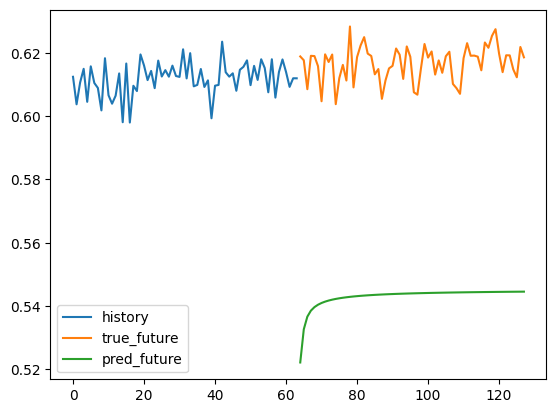

In [6]:
seg = y[8000:10000].astype(np.float32)
n, m = 64, 64
pos = 1800  # 注意：seg 内部下标，且 <= 1872

x = torch.from_numpy(seg[pos:pos+n]).unsqueeze(0).unsqueeze(-1).to(device)
y_true = seg[pos+n:pos+n+m]
y_pred = predict_autoregressive(net, x, m=m, device=device).squeeze().detach().cpu().numpy()

import matplotlib.pyplot as plt
plt.figure()
plt.plot(np.arange(n), seg[pos:pos+n], label="history")
plt.plot(np.arange(n, n+m), y_true, label="true_future")
plt.plot(np.arange(n, n+m), y_pred, label="pred_future")
plt.legend(); plt.show()
